In [38]:
import gym
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import random
from copy import deepcopy

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    if verbose:
        plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.best_action(s, len(actions))

In [4]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1 and verbose:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1 and verbose:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
    return reward

## Часть первая: крестики-нолики при помощи Q-обучения

#### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [17]:
class Strategy:
    def __init__(self):
        self.Q = dict()
    
    def best_action(self, s, a_n):
        if s in self.Q:
            return np.argmax(self.Q[s])
        else:
            return self.get_random(s, a_n)
    
    def get_random(self, s, a_n):
        if s not in self.Q:
            self.Q[s] = np.zeros(a_n)
        return np.random.randint(a_n)

In [18]:
idx = {1: 0, -1: 1}

def Q_learning_episode(env, pi, alpha=0.005, epsilon=0.2, gamma=1.0):
    env.reset()
    done = False
    prev_s = [None, None]  #  первый - для крестиков, второй - для ноликов
    prev_a = [None, None]
    s, actions, turn = env.getState()
    while not done:
        if np.random.rand() > epsilon:
            a_i = pi[idx[turn]].best_action(s, len(actions))
        else:
            a_i = pi[idx[turn]].get_random(s, len(actions))
        a = actions[a_i]
        observation, reward, done, _ = env.step(a)
        s_prime, actions_prime, turn_prime = observation
        op_idx = 1 - idx[turn]
        if prev_s[op_idx] is not None:
            ss, aa, Q = prev_s[op_idx], prev_a[op_idx], pi[op_idx].Q
            gamma_val = gamma * np.max(Q[s_prime]) if s_prime in Q else 0
            Q[ss][aa] = Q[ss][aa] + alpha * (-turn * reward + gamma_val - Q[ss][aa])
        if reward == turn:
            pi[idx[turn]].Q[s][a_i] = 1
        prev_s[idx[turn]] = s
        prev_a[idx[turn]] = a_i
        s, actions, turn = s_prime, actions_prime, turn_prime

In [231]:
def test_strategy(env, pi_1=None, pi_2=None, n_games=1000):
    total_reward = 0
    for i in range(n_games):
        total_reward += plot_test_game(env, pi1=pi_1, pi2=pi_2, 
                                       random_crosses=pi_1 is None, 
                                       random_naughts=pi_2 is None,
                                       verbose=False)
    return total_reward / n_games

In [242]:
env = TicTacToe(3, 3, 3)
total_episodes = 300000
test_step = 1000
test_games = 1000

pi = [Strategy(), Strategy()]

results = {'steps': [], 'cross_res': [], 'nought_res': []}

for n in tqdm.tqdm(range(1, total_episodes + 1)):
    Q_learning_episode(env, pi)
    if n % test_step == 0:
        cross_res = test_strategy(env, pi_1=pi[0], pi_2=None, n_games=test_games)
        nought_res = -test_strategy(env, pi_1=None, pi_2=pi[1], n_games=test_games)
        results['cross_res'].append(cross_res)
        results['nought_res'].append(nought_res)
        results['steps'].append(n)

100%|██████████| 300000/300000 [06:47<00:00, 735.68it/s] 


In [27]:
def plot_results(results):
    plt.figure(figsize=(10, 8))
    plt.xlabel('Кол-во эпизодов')
    plt.ylabel('Средняя награда')
    plt.plot(results['steps'], results['cross_res'], label='Крестики')
    plt.plot(results['steps'], results['nought_res'], label='Нолики')
    plt.legend()
    plt.show()

Результаты обучения стратегии на доске 3 на 3.

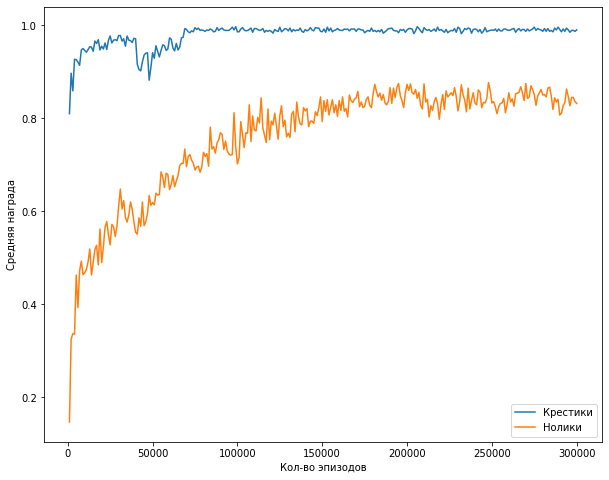

In [243]:
plot_results(results)

In [244]:
print('Средняя награда крестиков при рандомных ноликах:', results['cross_res'][-1])
print('Средняя награда ноликов при рандомных крестиках:', results['nought_res'][-1])

Средняя награда крестиков при рандомных ноликах: 0.99
Средняя награда ноликов при рандомных крестиках: 0.832


#### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [239]:
env = TicTacToe(4, 4, 4)
total_episodes = 1000000
test_step = 1000
test_games = 1000

pi = [Strategy(), Strategy()]

results = {'steps': [], 'cross_res': [], 'nought_res': []}

for n in tqdm.tqdm(range(1, total_episodes + 1)):
    Q_learning_episode(env, pi, alpha=0.009, epsilon=0.3)
    if n % test_step == 0:
        cross_res = test_strategy(env, pi_1=pi[0], pi_2=None, n_games=test_games)
        nought_res = -test_strategy(env, pi_1=None, pi_2=pi[1], n_games=test_games)
        results['cross_res'].append(cross_res)
        results['nought_res'].append(nought_res)
        results['steps'].append(n)

100%|██████████| 1000000/1000000 [53:55<00:00, 309.08it/s] 


Результаты обучения стратегии на доске 4 на 4.

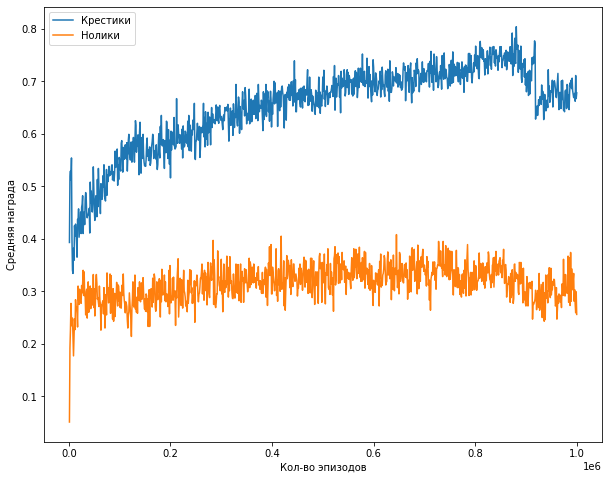

In [240]:
plot_results(results)

In [241]:
print('Средняя награда крестиков при рандомных ноликах:', results['cross_res'][-1])
print('Средняя награда ноликов при рандомных крестиках:', results['nought_res'][-1])

Средняя награда крестиков при рандомных ноликах: 0.678
Средняя награда ноликов при рандомных крестиках: 0.256


## Часть вторая: добавим нейронных сетей

#### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, 128, (3, 3))
        self.fc_1 = nn.Linear(128, 64)
        self.fc_2 = nn.Linear(64, 9)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [22]:
class DQN:
    def __init__(self, model=Network):
        self.env = TicTacToe(3, 3, 3)
        self.model = [model().to(device), model().to(device)]
        self.memory = [ReplayMemory(1000000), ReplayMemory(1000000)]
        self.optimizer = [optim.Adam(self.model[0].parameters(), lr=3e-4), 
                          optim.Adam(self.model[1].parameters(), lr=3e-4)]
        self.prev_s = [None, None]
        self.prev_a = [None, None]
        
        self.gamma = 0.8
        self.batch_size = 1024
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 10000
        self.num_step = 0
    
    def to_tensor(self, s):
        size = 3
        crosses = np.array([1 if i == '2' else 0 for i in s]).reshape(size, size)
        noughts = np.array([1 if i == '0' else 0 for i in s]).reshape(size, size)
        spaces = np.array([1 if i == '1' else 0 for i in s]).reshape(size, size)
        return torch.Tensor(np.stack([crosses, noughts, spaces])).reshape(3, size, size)

    def select_greedy_action(self, state, turn):
        return self.model[idx[turn]](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, turn):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * np.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, turn)
        else:
            return torch.tensor([[random.randrange(9)]], dtype=torch.int64)
        
    def run_episode(self, do_learning=True, greedy=False):
        self.env.reset()
        done = False
        self.prev_s = [None, None]
        self.prev_a = [None, None]
        state, actions, turn = self.env.getState()
        while not done:
            state_tensor = self.to_tensor(state)
            with torch.no_grad():
                if greedy:
                    a_i = self.select_greedy_action(state_tensor.to(device), turn).cpu()
                else:
                    a_i = self.select_action(state_tensor.to(device), turn).cpu()
            
            self.prev_s[idx[turn]] = state_tensor
            self.prev_a[idx[turn]] = a_i
            action = self.env.action_from_int(a_i.numpy()[0][0])
            observation, reward, done, _ = self.env.step(action)
            next_state, actions, turn = observation
            next_state_tensor = self.to_tensor(next_state)

            if reward == -10:
                transition = (state_tensor, a_i, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memory[idx[turn]].store(transition)
            else:
                if self.prev_s[idx[turn]] is not None:
                    transition = (self.prev_s[idx[turn]], self.prev_a[idx[turn]], next_state_tensor, torch.tensor([turn*reward], dtype=torch.float32))
                    self.memory[idx[turn]].store(transition)
                
            if do_learning:
                self.learn(turn)
            state = next_state

    def learn(self, turn):
        if min(len(self.memory[0]), len(self.memory[1])) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory[idx[turn]].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state).to(device))
        batch_state = batch_state.reshape(self.batch_size, 3, 3, 3)
        batch_action = Variable(torch.cat(batch_action).to(device))
        batch_reward = Variable(torch.cat(batch_reward).to(device))
        batch_next_state = Variable(torch.cat(batch_next_state).to(device))
        batch_next_state = batch_next_state.reshape(self.batch_size, 3, 3, 3)

        # считаем значения функции Q
        Q = self.model[idx[turn]](batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model[idx[turn]](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer[idx[turn]].zero_grad()
        loss.backward()
        self.optimizer[idx[turn]].step()

In [23]:
def test_strategy(dqn, player, n_games):
    total_reward = 0
    for i in range(n_games):
        dqn.env.reset()
        state, actions, turn = dqn.env.getState()
        done = False
        while not done:
            if turn == player:
                a_i = dqn.select_greedy_action(dqn.to_tensor(state).to(device), player)
                a = dqn.env.action_from_int(a_i)
            else:
                a_i = np.random.randint(len(actions))
                a = actions[a_i]
            observation, reward, done, _ = dqn.env.step(a)
            state, actions, turn = observation
        if reward != -10 and reward == player:
            total_reward += 1
    return total_reward / n_games

In [25]:
dqn = DQN()
total_episodes = 50000
test_step = 1000
test_games = 1000

results = {'steps': [], 'cross_res': [], 'nought_res': []}

for n in tqdm.tqdm(range(1, total_episodes + 1)):
    dqn.run_episode()
    if n % test_step == 0:
        cross_res = test_strategy(dqn, player=1, n_games=test_games)
        nought_res = test_strategy(dqn, player=-1, n_games=test_games)
        results['cross_res'].append(cross_res)
        results['nought_res'].append(nought_res)
        results['steps'].append(n)

100%|██████████| 50000/50000 [58:21<00:00, 14.28it/s]  


Результаты модели DQN.

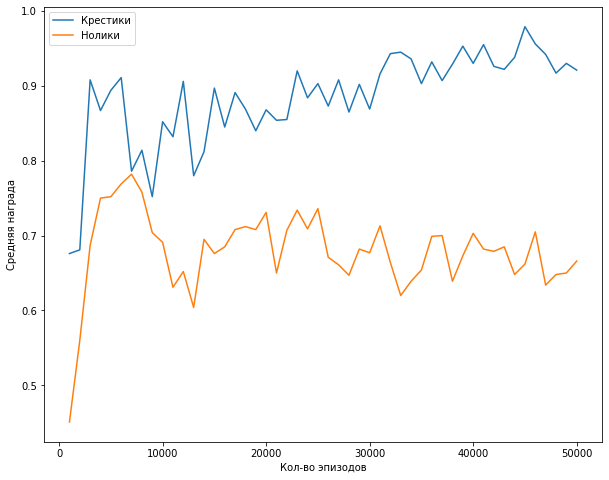

In [28]:
plot_results(results)

Результаты не супер, но скорее всего стоило больше поиграться с параметрами.

#### 4. Реализуйте Double DQN и/или Dueling DQN.

In [29]:
class Dueling_Network(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, 128, (3, 3))
        self.fc_1 = nn.Linear(128, 64)
        self.fc_2 = nn.Linear(64, 1)
        self.fc_3 = nn.Linear(64, 9)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        value = self.fc_2(x)
        adv = self.fc_3(x)
        x = value + adv - torch.mean(adv, dim=1, keepdim=True)
        return x

In [30]:
dqn = DQN(model=Dueling_Network)
total_episodes = 50000
test_step = 1000
test_games = 1000

results = {'steps': [], 'cross_res': [], 'nought_res': []}

for n in tqdm.tqdm(range(1, total_episodes + 1)):
    dqn.run_episode()
    if n % test_step == 0:
        cross_res = test_strategy(dqn, player=1, n_games=test_games)
        nought_res = test_strategy(dqn, player=-1, n_games=test_games)
        results['cross_res'].append(cross_res)
        results['nought_res'].append(nought_res)
        results['steps'].append(n)

100%|██████████| 50000/50000 [1:07:03<00:00, 12.43it/s]  


Результаты обучения модели Dueling DQN.

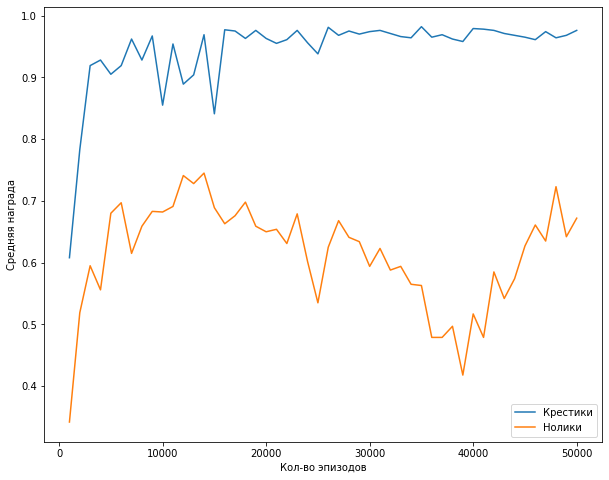

In [31]:
plot_results(results)

В целом заметно, что Dueling DQN обучается лучше, чем DQN (в частности, для крестиков). Для ноликов наблюдается небольшой спад с течением времени. Возможно, происходило переобучение и стоило уменьшить learning rate.

## Часть третья: расширим и углубим поиск

#### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [32]:
class RandomStrategy:
    def __init__(self):
        self.Q = dict()
    
    def best_action(self, s, a_n):
        return self.get_random(s, a_n)
    
    def get_random(self, s, a_n):
        return np.random.randint(a_n)

In [47]:
def rollouts(env, pi, n_rollouts):
    results = []
    _, actions, _ = env.getState()
    for action in actions:
        rewards = []
        for i in range(n_rollouts):
            env_copy = deepcopy(env)
            observation, reward, done, _ = env_copy.step(action)
            state, acts, turn = observation
            while not done:
                if pi[idx[turn]] is not None:
                    a_i = pi[idx[turn]].best_action(state, len(acts))
                else:
                    a_i = np.random.randint(len(acts))
                a = acts[a_i]
                observation, reward, done, _ = env_copy.step(a)
                state, acts, turn = observation
            rewards.append(reward)
        results.append(np.mean(rewards))
    return np.argmax(results) if pi[0] is not None else np.argmin(results)

In [52]:
def test_strategy_with_rollouts(env, pi, n_games, n_rollouts, verbose=True):
    total_reward = 0
    if verbose:
        iterator = tqdm.tqdm(range(n_games))
    else:
        iterator = range(n_games)
    for i in iterator:
        env.reset()
        state, actions, turn = env.getState()
        done = False
        while not done:
            if pi[idx[turn]] is not None:
                a_i = rollouts(env, pi, n_rollouts)
            else:
                a_i = np.random.randint(len(actions))
            a = actions[a_i]
            observation, reward, done, _ = env.step(a)
            state, actions, turn = observation
        total_reward += reward
    return total_reward / n_games

In [40]:
env = TicTacToe(3, 3, 3)
test_games = 1000
n_rollouts = 100

pi = [RandomStrategy(), None]
result = test_strategy_with_rollouts(env, pi, test_games, n_rollouts)

100%|██████████| 1000/1000 [13:00<00:00,  1.28it/s]


In [41]:
print("Средняя награда для рандомных крестиков с rollouts:", result)

Средняя награда для рандомных крестиков с rollouts: 0.99


In [49]:
env = TicTacToe(3, 3, 3)
test_games = 1000
n_rollouts = 100

pi = [None, RandomStrategy()]
result = test_strategy_with_rollouts(env, pi, test_games, n_rollouts)

100%|██████████| 1000/1000 [09:52<00:00,  1.69it/s]


In [50]:
print("Средняя награда для рандомных ноликов с rollouts:", -result)

Средняя награда для рандомных ноликов с rollouts: 0.876


#### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [ ]:
class Node:
    def __init__(self, parent, actions, turn):
        self.n = 0
        self.w = 0
        self.children = dict()
        self.parent = parent
        self.actions = actions
        self.turn = turn

In [216]:
class MCTS:
    def __init__(self, env):
        self.env = env
        self.root = None
        self.c = 1.0
    
    def rollout(self):
        done = False
        observation, actions, turn = self.env.getState()
        while not done:
            a = actions[np.random.randint(len(actions))]
            state, reward, done, _ = self.env.step(a)
            observation, actions, turn = state
        return reward
        
    
    def best_action_by_uct(self, node):
        values = []
        for i, action in enumerate(node.actions):
            a_int = self.env.int_from_action(action)
            exploit = node.children[a_int].w / node.children[a_int].n
            explore = self.c * np.sqrt(np.log(node.n) / node.children[a_int].n)
            values.append((action, exploit+explore))
        return max(values, key=lambda x: x[1])[0]
    
    def first_unexplored(self, node):
        for action in node.actions:
            a_int = self.env.int_from_action(action)
            if a_int not in node.children:
                return action
    
    def run_episode(self, player):
        self.env.reset()
        done = False
        state, actions, turn = self.env.getState()
        if self.root is None:
            self.root = Node(None, actions, turn)
        node = self.root
        while not done:
            if node.n == 0:
                reward = self.rollout()
                break
            if turn == player:
                if len(node.children) == len(node.actions):
                    a = self.best_action_by_uct(node)
                else:
                    a = self.first_unexplored(node)
            else:
                a = actions[np.random.randint(len(actions))]
            
            observation, reward, done, _ = self.env.step(a)
            state, actions, turn = observation
            a_int = self.env.int_from_action(a)
            if a_int in node.children:
                node = node.children[a_int]
            else:
                new_node = Node(node, actions, turn)
                node.children[a_int] = new_node
                node = new_node
        
        while node:
            node.n += 1
            if -node.turn == reward:
                node.w += 1
            node = node.parent

In [217]:
def test_mcts_strategy(mcts, player, n_games):
    env = mcts.env
    total_reward = 0
    for i in range(n_games):
        env.reset()
        node = mcts.root
        state, actions, turn = env.getState()
        done = False
        while not done:
            if turn == player:
                if len(node.children) == len(node.actions) and len(node.actions):
                    a = mcts.best_action_by_uct(node)
                else:
                    reward = mcts.rollout()
                    break
            else:
                a = actions[np.random.randint(len(actions))]
            observation, reward, done, _ = env.step(a)
            if not done:
                state, actions, turn = observation
                a_int = env.int_from_action(a)
                if a_int in node.children:
                    node = node.children[a_int]
                else:
                    reward = mcts.rollout()
                    break
        if player == reward:
            total_reward += 1
    return total_reward / n_games

In [221]:
env_1, env_2 = TicTacToe(3, 3, 3), TicTacToe(3, 3, 3)
mcts_cross, mcts_nought = MCTS(env_1), MCTS(env_2)

total_episodes = 200000
test_step = 1000
test_games = 1000

results = {'steps': [], 'cross_res': [], 'nought_res': []}

for n in tqdm.tqdm(range(1, total_episodes+1)):
    mcts_cross.run_episode(1)
    mcts_nought.run_episode(-1)
    if n % test_step == 0:
        cross_res = test_mcts_strategy(mcts_cross, player=1, n_games=test_games)
        nought_res = test_mcts_strategy(mcts_nought, player=-1, n_games=test_games)
        results['cross_res'].append(cross_res)
        results['nought_res'].append(nought_res)
        results['steps'].append(n)


100%|██████████| 200000/200000 [06:52<00:00, 484.33it/s]


Крестики-нолики 3 на 3. MCTS с rollouts

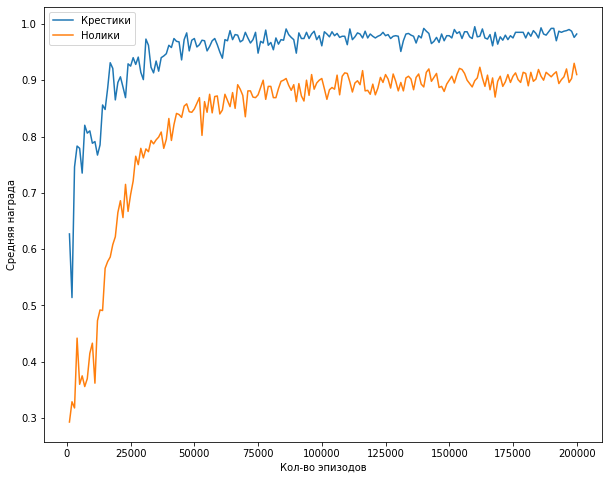

In [222]:
plot_results(results)

Крестики-нолики 4 на 4. MCTS с rollouts

In [223]:
env_1, env_2 = TicTacToe(4, 4, 4), TicTacToe(4, 4, 4)
mcts_cross, mcts_nought = MCTS(env_1), MCTS(env_2)

total_episodes = 1000000
test_step = 1000
test_games = 1000

results = {'steps': [], 'cross_res': [], 'nought_res': []}

for n in tqdm.tqdm(range(1, total_episodes+1)):
    mcts_cross.run_episode(1)
    mcts_nought.run_episode(-1)
    if n % test_step == 0:
        cross_res = test_mcts_strategy(mcts_cross, player=1, n_games=test_games)
        nought_res = test_mcts_strategy(mcts_nought, player=-1, n_games=test_games)
        results['cross_res'].append(cross_res)
        results['nought_res'].append(nought_res)
        results['steps'].append(n)

100%|██████████| 1000000/1000000 [1:24:13<00:00, 197.89it/s]


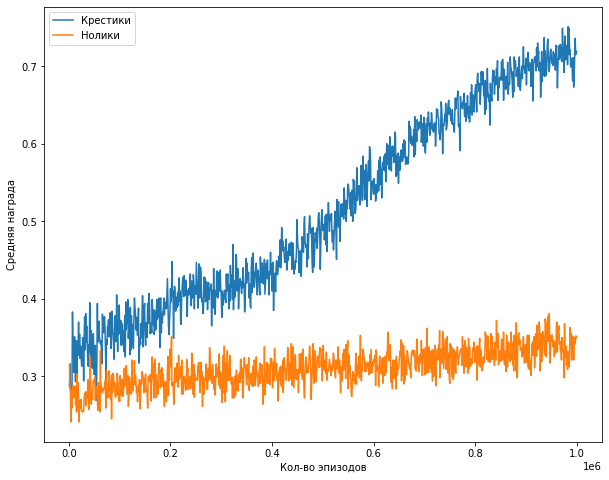

In [224]:
plot_results(results)

Результаты MCTS с rollouts в какой-то степени сопоставимы с Q-learning, если говорить про крестиков. Для ноликов MCTS, кажется, работает лучше. К сожалению, DQN не смог показать заметно хорошего результата, а Dueling DQN не смог похвастаться преимуществом над MCTS. Однако, это могло произойти из-за недостаточно подходящих параметров модели, которые я указал. 

Что касаемо игры на доске 4x4, результаты всё также похожи на результаты c Q-learning.